# **GPU Information**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sun Aug 14 14:46:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Packages**

In [ ]:
import torch
import torchvision
import time
import math
import copy
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal


%matplotlib inline

# **Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **FashionMNIST Dataset**

In [ ]:
fmnist_trainset = torchvision.datasets.FashionMNIST('./fmnist/', train=True, download=True, 
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(), 
                                       ]))

fmnist_trainset, fmnist_valset = torch.utils.data.random_split(fmnist_trainset, [50000, 10000])

fmnist_testset = torchvision.datasets.FashionMNIST('./fmnist/', train=False, download=True, 
                                  transform=torchvision.transforms.Compose([ 
                                      torchvision.transforms.ToTensor(),  
                                      ]))

fmnist_train_loader = torch.utils.data.DataLoader(fmnist_trainset, batch_size=100, shuffle=True)

fmnist_val_loader = torch.utils.data.DataLoader(fmnist_valset, batch_size=100, shuffle=True)

fmnist_test_loader = torch.utils.data.DataLoader(fmnist_testset, batch_size=100, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



# **Bayesian Modules**

In [ ]:
class Gaussian():
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()
    
    
class ScaleMixtureGaussian():
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = Normal(0,sigma1)
        self.gaussian2 = Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()
    
    


class GuassianLinear(nn.Module):
    
    def __init__(self,
                 in_features, 
                 out_features, 
                 PI = 0.5, 
                 SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), 
                 SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))):
        
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input_data, sample=True, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input_data, weight, bias)
    
    
class GuassianConvolution2D(nn.Module):
    
    def __init__(self, 
                 in_features, 
                 out_features, 
                 kernel_size,
                 stride = 1, 
                 padding = 0, 
                 dilation = 1,
                 PI = 0.5, 
                 SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")),  
                 SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))):
        
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation =dilation
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features, self.kernel_size, self.kernel_size).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features, self.kernel_size, self.kernel_size).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0
        
    def forward(self, input_data, sample=True, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.conv2d(input_data, weight, bias, stride = self.stride, padding = self.padding, dilation = self.dilation)

# **Bayesian LeNet5**

In [ ]:
class BayesianLeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GuassianConvolution2D(1, 16, 5)
        self.conv2 = GuassianConvolution2D(16, 32, 5)
        self.linear1 = GuassianLinear(512, 128)
        self.linear2 = GuassianLinear(128, 10)
    
    def forward(self, x, sample=True):
        out = self.conv1(x, sample)
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = F.relu(out)
        
        out = self.conv2(out, sample)
        out = F.max_pool2d(out, kernel_size = 2, stride = 2)
        out = F.relu(out)
        
        out = out.view(-1, 512)
        
        out = self.linear1(out, sample)
        out = F.relu(out)
        
        out = self.linear2(out, sample)
        output = F.log_softmax(out, dim = -1)
        return output
    
    def log_prior(self):
        return self.conv1.log_prior \
               + self.conv2.log_prior \
               + self.linear1.log_prior \
               + self.linear2.log_prior
    
    def log_variational_posterior(self):
        return self.conv1.log_variational_posterior \
               + self.conv2.log_variational_posterior \
               + self.linear1.log_variational_posterior \
               + self.linear2.log_variational_posterior
    
    def sample_elbo(self, 
                    x, 
                    target, 
                    BATCH_SIZE, 
                    NUM_BATCHES, 
                    samples = 2, 
                    CLASSES = 10, 
                    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        
        for i in range(samples):
            outputs[i] = self(x, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='sum')
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Variational Inference**

**Define LeNet5 Training Process**

In [ ]:
def BayesianLeNet5training(train_loader, val_loader, nepochs, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 

    model = BayesianLeNet5().to(device)
    model.train()
            
    optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
    optimizer.zero_grad()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = nepochs, eta_min= 1e-4)

    if track: 
        Loss = []
        Acc = []
        LR = []

    batchLen = len(train_loader)
    nval = len(val_loader) * nbatch
    digitsBatchLen = len(str(batchLen))
    
    for n in np.arange(nepochs): 
        
        if track: 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

        for batch_id, sample in enumerate(train_loader):
                    
            images, labels = sample
            images, labels = images.to(device), labels.to(device)
                    
            loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)
                    
            optimizer.zero_grad()
            loss.backward()
                    
            optimizer.step()
                    
            if track: 

                Loss.append(loss.detach().cpu().item())
                    
            print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                      n+1, nepochs,
                                                      batch_id+1,
                                                      batchLen, 
                                                      loss.detach().cpu().item()), 
                        end="")
        print("")

        if track: 

            LR.append(scheduler.get_last_lr())

        scheduler.step()

        if ((n == nepochs - 1) and track):

            #LR.append(scheduler.get_last_lr()) 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

    if track:
        
        return model, Loss, Acc, LR

    else: 
        return model

**Training**

In [ ]:
Lemodel, LeLoss, LeAcc, LeLR = BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 30, track = True)


Accuracy on Validation Set: 977.0/10000 (9.7700%)

--------------------------------------------------------
 	Epoch 1/30: Train step 500/500 loss = 737.0350

Accuracy on Validation Set: 7635.0/10000 (76.3500%)

--------------------------------------------------------
 	Epoch 2/30: Train step 500/500 loss = 713.5787

Accuracy on Validation Set: 7883.0/10000 (78.8300%)

--------------------------------------------------------
 	Epoch 3/30: Train step 500/500 loss = 715.1120

Accuracy on Validation Set: 8365.0/10000 (83.6500%)

--------------------------------------------------------
 	Epoch 4/30: Train step 500/500 loss = 696.1877

Accuracy on Validation Set: 8450.0/10000 (84.5000%)

--------------------------------------------------------
 	Epoch 5/30: Train step 500/500 loss = 697.0365

Accuracy on Validation Set: 8483.0/10000 (84.8300%)

--------------------------------------------------------
 	Epoch 6/30: Train step 500/500 loss = 707.0998

Accuracy on Validation Set: 8466.0/10000 

**Training Accuracy on Validation Set**

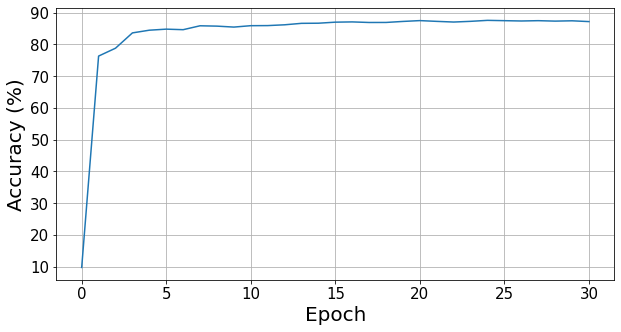

In [ ]:
fs = 20
LeAcc_fig = plt.figure(figsize=(10,5))
plt.plot(LeAcc)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
LeAcc_fig.savefig("LeAcc_fig.png")

**Training Loss on Trainset**

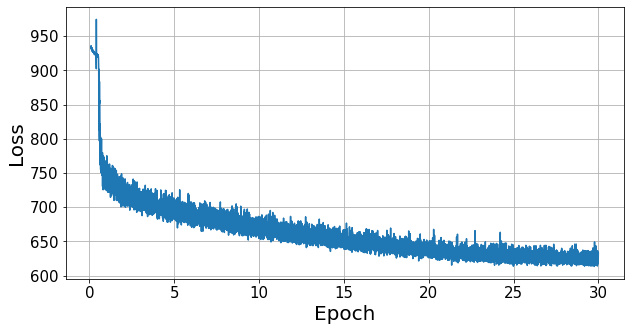

In [ ]:
fs = 20
LeLoss_fig = plt.figure(figsize=(10,5))
x = np.arange(len(LeLoss))[50:] / 500.
plt.plot(x, LeLoss[50:])
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
LeLoss_fig.savefig("LeLoss_fig.png")

**Learning Rate Schedule**

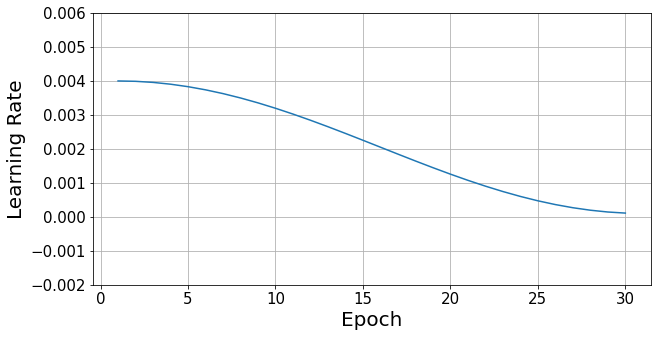

In [ ]:
fs = 20
LeLR_fig = plt.figure(figsize=(10,5))
x = np.arange(len(LeLR)) + 1
plt.plot(x, LeLR)
plt.grid()
plt.ylim(-0.002,0.006)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Learning Rate',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
LeLR_fig.savefig("LeLR_fig.png")

**Calculate Training Time**

In [ ]:
Letraining_start = time.time()

%time model = BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 30, nbatch = 100, track = False)

Letraining_end = time.time()

Letraining_time = Letraining_end - Letraining_start

print(Letraining_time)

 	Epoch 1/30: Train step 500/500 loss = 719.9009
 	Epoch 2/30: Train step 500/500 loss = 695.5928
 	Epoch 3/30: Train step 500/500 loss = 697.9977
 	Epoch 4/30: Train step 500/500 loss = 708.6816
 	Epoch 5/30: Train step 500/500 loss = 674.5538
 	Epoch 6/30: Train step 500/500 loss = 676.2324
 	Epoch 7/30: Train step 500/500 loss = 669.2131
 	Epoch 8/30: Train step 500/500 loss = 673.9830
 	Epoch 9/30: Train step 500/500 loss = 667.8261
 	Epoch 10/30: Train step 500/500 loss = 658.7340
 	Epoch 11/30: Train step 500/500 loss = 665.0228
 	Epoch 12/30: Train step 500/500 loss = 644.1691
 	Epoch 13/30: Train step 500/500 loss = 643.5982
 	Epoch 14/30: Train step 500/500 loss = 641.3750
 	Epoch 15/30: Train step 500/500 loss = 640.8989
 	Epoch 16/30: Train step 500/500 loss = 622.2455
 	Epoch 17/30: Train step 500/500 loss = 629.2302
 	Epoch 18/30: Train step 500/500 loss = 628.6831
 	Epoch 19/30: Train step 500/500 loss = 625.3390
 	Epoch 20/30: Train step 500/500 loss = 621.3654
 	Epoch 2

In [ ]:
np.save('./Letraining_time.npy', Letraining_time)

**Accuracy on Testset**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10

with torch.no_grad(): 

    Lemodel.to(device)
    Lemodel.eval()

    correct = 0

    for batch_id, sample in enumerate(fmnist_test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            pred = Lemodel(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(fmnist_testset), correct/len(fmnist_testset) * 100.))
    
    Leacc = correct/len(fmnist_testset) * 100.



Accuracy on Test Set: 8725.0/10000 (87.2500%)



In [ ]:
np.save('./Leacc.npy', Leacc)

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Traditional Ensemble + Variational Inference**

**Define LeNet5 Ensemble Training Process**

In [ ]:
def ensemble_BayesianLeNet5training(train_loader, val_loader, nepochs, nmodels, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 
    
    Models = {}

    if track: 

        Loss = {}
        Acc = {}
        LR = {}

    batchLen = len(train_loader)
    nval = len(val_loader) * nbatch
    digitsBatchLen = len(str(batchLen))

    for i in np.arange(nmodels): 
        print("Training model {}/{}:".format(i+1, nmodels))

        model = BayesianLeNet5().to(device)
        model.train()
                
        optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
        optimizer.zero_grad()

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = nepochs, eta_min= 1e-4)

        if track: 
            Loss[i] = []
            Acc[i] = []
            LR[i] = []

        for n in np.arange(nepochs):

            if track: 

                correct = 0
                for batch_id, sample in enumerate(val_loader) :

                    images, labels = sample
                    images, labels = images.to(device), labels.to(device)
                    
                    pred = model(images)
                    pred = pred.argmax(dim = 1)
                    correct += pred.eq(labels).float().sum().item()
                print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                    correct, nval, correct/nval * 100.))
                print("--------------------------------------------------------")
                
                Acc[i].append(correct/nval * 100.)
            
            for batch_id, sample in enumerate(train_loader):
                        
                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                        
                loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                if track: 

                    Loss[i].append(loss.detach().cpu().item())
                        
                print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                          n+1, nepochs,
                                                          batch_id+1,
                                                          batchLen, 
                                                          loss.detach().cpu().item()), 
                            end="")
            print("")

            if track: 
              
                LR[i].append(scheduler.get_last_lr())

            scheduler.step()

            if ((n == nepochs - 1) and track):

                #LR[i].append(scheduler.get_last_lr()) 

                correct = 0
                for batch_id, sample in enumerate(val_loader) :

                    images, labels = sample
                    images, labels = images.to(device), labels.to(device)
                
                    pred = model(images)
                    pred = pred.argmax(dim = 1)
                    correct += pred.eq(labels).float().sum().item()
                print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                    correct, nval, correct/nval * 100.))
                print("--------------------------------------------------------")
            
                Acc[i].append(correct/nval * 100.)

        Models[i] = model

        print("========================================================")

    if track: 

        return Models, Loss, Acc, LR

    else:

        return Models

**Ensemble Training**

In [ ]:
Ens_LeModels, Ens_LeLoss, Ens_LeAcc, Ens_LeLR = ensemble_BayesianLeNet5training(train_loader = fmnist_train_loader, 
                                           val_loader = fmnist_val_loader, 
                                           nepochs = 30, 
                                           nmodels = 10, 
                                           nbatch = 100, 
                                           track = True)

Training model 1/10:

Accuracy on Validation Set: 313.0/10000 (3.1300%)

--------------------------------------------------------
 	Epoch 1/30: Train step 500/500 loss = 716.4076

Accuracy on Validation Set: 8344.0/10000 (83.4400%)

--------------------------------------------------------
 	Epoch 2/30: Train step 500/500 loss = 720.7593

Accuracy on Validation Set: 8395.0/10000 (83.9500%)

--------------------------------------------------------
 	Epoch 3/30: Train step 500/500 loss = 702.9644

Accuracy on Validation Set: 8590.0/10000 (85.9000%)

--------------------------------------------------------
 	Epoch 4/30: Train step 500/500 loss = 706.7995

Accuracy on Validation Set: 8406.0/10000 (84.0600%)

--------------------------------------------------------
 	Epoch 5/30: Train step 500/500 loss = 677.4136

Accuracy on Validation Set: 8719.0/10000 (87.1900%)

--------------------------------------------------------
 	Epoch 6/30: Train step 500/500 loss = 702.2288

Accuracy on Validati

**Training Accuracy on Validation Set**

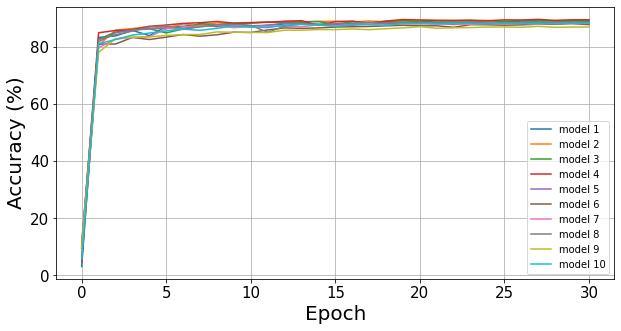

In [ ]:
fs = 20
Ens_LeAcc_fig = plt.figure(figsize=(10,5))
for i in range(len(Ens_LeAcc)): 
  plt.plot(Ens_LeAcc[i], label = "model {}".format(i+1))
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
Ens_LeAcc_fig.savefig("Ens_LeAcc_fig.png")

**Training Loss on Trainset**

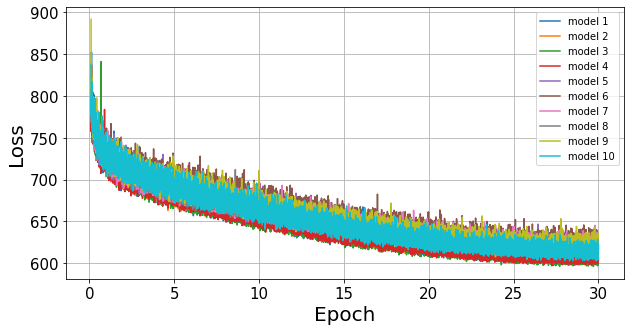

In [ ]:
fs = 20
Ens_LeLoss_fig = plt.figure(figsize=(10,5))
for i in range(len(Ens_LeLoss)): 
    x = np.arange(len(Ens_LeLoss[i]))[50:] / 500.
    plt.plot(x, Ens_LeLoss[i][50:], label = "model {}".format(i+1))
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss',fontsize=fs)
plt.tick_params(labelsize=15)
plt.legend()
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
Ens_LeLoss_fig.savefig("Ens_LeLoss_fig.png")

**Accuracy on Testset**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10
nmodels = 10

with torch.no_grad(): 

    correct = 0

    for batch_id, sample in enumerate(fmnist_test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            model_num = np.random.randint(nmodels)
            model = Ens_LeModels[model_num]

            model.to(device)
            model.eval()

            pred = model(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(fmnist_testset), correct/len(fmnist_testset) * 100.))
    
    Ens_Leacc = correct/len(fmnist_testset) * 100.



Accuracy on Test Set: 9148.0/10000 (91.4800%)



In [ ]:
np.save('./Ens_Leacc.npy', Ens_Leacc)

In [ ]:
Ens_Letraining_start = time.time()

%time Ens_LeModels = ensemble_BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 30, nmodels = 10, nbatch = 100, track = False)

Ens_Letraining_end = time.time()

Ens_Letraining_time = Ens_Letraining_end - Ens_Letraining_start

print(Ens_Letraining_time)

Training model 1/10:
 	Epoch 1/30: Train step 500/500 loss = 745.4479
 	Epoch 2/30: Train step 500/500 loss = 709.8669
 	Epoch 3/30: Train step 500/500 loss = 701.3973
 	Epoch 4/30: Train step 500/500 loss = 676.6231
 	Epoch 5/30: Train step 500/500 loss = 687.2488
 	Epoch 6/30: Train step 500/500 loss = 679.7102
 	Epoch 7/30: Train step 500/500 loss = 683.6936
 	Epoch 8/30: Train step 500/500 loss = 664.7177
 	Epoch 9/30: Train step 500/500 loss = 658.5107
 	Epoch 10/30: Train step 500/500 loss = 660.7827
 	Epoch 11/30: Train step 500/500 loss = 653.6680
 	Epoch 12/30: Train step 500/500 loss = 649.7383
 	Epoch 13/30: Train step 500/500 loss = 654.9467
 	Epoch 14/30: Train step 500/500 loss = 641.9108
 	Epoch 15/30: Train step 500/500 loss = 632.6600
 	Epoch 16/30: Train step 500/500 loss = 628.4696
 	Epoch 17/30: Train step 500/500 loss = 628.2919
 	Epoch 18/30: Train step 500/500 loss = 629.1528
 	Epoch 19/30: Train step 500/500 loss = 621.6343
 	Epoch 20/30: Train step 500/500 loss

In [ ]:
np.save('./Ens_Letraining_time.npy', Ens_Letraining_time)

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Snapshot Ensemble + Variational Inference**

**Define Snapshot Ensembling Training Process**

In [ ]:
def snap_ensemble_BayesianLeNet5training(train_loader, val_loader, nepochs, nmodels, nbatch = 100, track = True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 
    
    Models = {}
    model = BayesianLeNet5().to(device)
    model.train()

    optimizer = torch.optim.SGD(model.parameters(), lr = 4e-3)
    optimizer.zero_grad()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = nepochs, eta_min=1e-4)

    if track: 
        Loss = []
        Acc = []
        LR = []

    batchLen = len(train_loader)
    nval = len(val_loader) * nbatch
    digitsBatchLen = len(str(batchLen))
    
    for n in np.arange(nepochs * nmodels): 
        
        if track: 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

        for batch_id, sample in enumerate(train_loader):
                    
            images, labels = sample
            images, labels = images.to(device), labels.to(device)
                    
            loss, log_prior, log_variational_posterior, negative_log_likelihood = model.sample_elbo(images, labels, BATCH_SIZE = nbatch, NUM_BATCHES = batchLen)
                    
            optimizer.zero_grad()
            loss.backward()
                    
            optimizer.step()
                    
            if track: 

                Loss.append(loss.detach().cpu().item())
                    
            print("\r", ("\tEpoch {}/{}: Train step {"+(":0{}d".format(digitsBatchLen))+"}/{} loss = {:.4f}").format(
                                                      n+1, nepochs * nmodels,
                                                      batch_id+1,
                                                      batchLen, 
                                                      loss.detach().cpu().item()), 
                        end="")
        print("")

        if track: 

          LR.append(scheduler.get_last_lr())

        scheduler.step()

        if ((n == nepochs - 1) and track): 

            correct = 0
            for batch_id, sample in enumerate(val_loader) :

                images, labels = sample
                images, labels = images.to(device), labels.to(device)
                
                pred = model(images)
                pred = pred.argmax(dim = 1)
                correct += pred.eq(labels).float().sum().item()
            print("\nAccuracy on Validation Set: {}/{} ({:.4f}%)\n".format(
                correct, nval, correct/nval * 100.))
            print("--------------------------------------------------------")
            
            Acc.append(correct/nval * 100.)

        if (n + 1) % nepochs == 0:

            #stored_model = copy.deepcopy(model)

            torch.save(model.state_dict(), 'model {}.pth'.format(int((n + 1) / nepochs) - 1))

            stored_model = BayesianLeNet5().to(device)

            stored_model.load_state_dict(torch.load('model {}.pth'.format(int((n + 1) / nepochs) - 1)))

            Models[int((n + 1) / nepochs) - 1] = stored_model

            print("\n========================================================")

            print("model {} is saved into ensemble".format(int((n + 1) / nepochs)))

            print("{} model(s) has been saved".format(len(Models)))

            print("========================================================\n")

    if track: 

        return Models, Loss, Acc, LR

    else:

        return Models


**Snapshot Ensembling Training**

In [ ]:
Snap_Ens_LeModels, Snap_Ens_LeLoss, Snap_Ens_LeAcc, Snap_Ens_LeLR = snap_ensemble_BayesianLeNet5training(train_loader = fmnist_train_loader, 
                                                           val_loader = fmnist_val_loader, 
                                                           nepochs = 30, 
                                                           nmodels = 10, 
                                                           nbatch = 100, 
                                                           track = True)


Accuracy on Validation Set: 992.0/10000 (9.9200%)

--------------------------------------------------------
 	Epoch 1/300: Train step 500/500 loss = 726.7603

Accuracy on Validation Set: 8162.0/10000 (81.6200%)

--------------------------------------------------------
 	Epoch 2/300: Train step 500/500 loss = 705.2152

Accuracy on Validation Set: 8322.0/10000 (83.2200%)

--------------------------------------------------------
 	Epoch 3/300: Train step 500/500 loss = 702.5932

Accuracy on Validation Set: 8505.0/10000 (85.0500%)

--------------------------------------------------------
 	Epoch 4/300: Train step 500/500 loss = 696.4178

Accuracy on Validation Set: 8600.0/10000 (86.0000%)

--------------------------------------------------------
 	Epoch 5/300: Train step 500/500 loss = 697.5739

Accuracy on Validation Set: 8653.0/10000 (86.5300%)

--------------------------------------------------------
 	Epoch 6/300: Train step 500/500 loss = 690.9974

Accuracy on Validation Set: 8593.0/

**Training Accuracy on Validation Set**

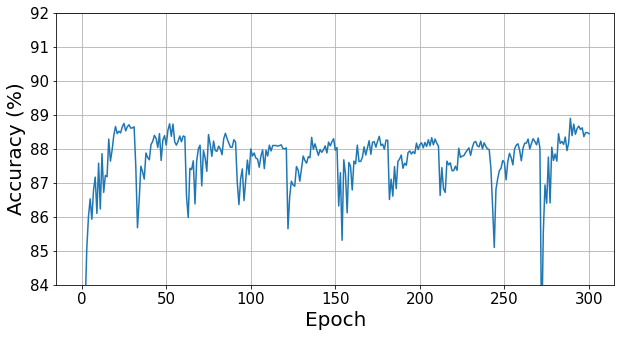

In [ ]:
fs = 20
Snap_Ens_LeAcc_fig = plt.figure(figsize=(10,5))
plt.plot(Snap_Ens_LeAcc)
plt.grid()
plt.ylim(84,92)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy (%)',fontsize=fs)
plt.tick_params(labelsize=15)
#plt.legend()
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
Snap_Ens_LeAcc_fig.savefig("Snap_Ens_LeAcc_fig.png")

**Training Loss on Trainset**

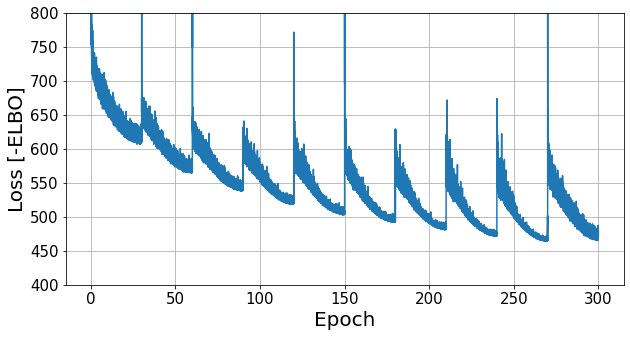

In [ ]:
fs = 20
Snap_Ens_LeLoss_fig = plt.figure(figsize=(10,5))
x = np.arange(len(Snap_Ens_LeLoss))[50:] / 500.
plt.plot(x, Snap_Ens_LeLoss[50:])
plt.grid()
plt.ylim(400,800)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss [-ELBO]',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
Snap_Ens_LeLoss_fig.savefig("Snap_Ens_LeLoss_fig.png")

**Learning Rate Schedule**

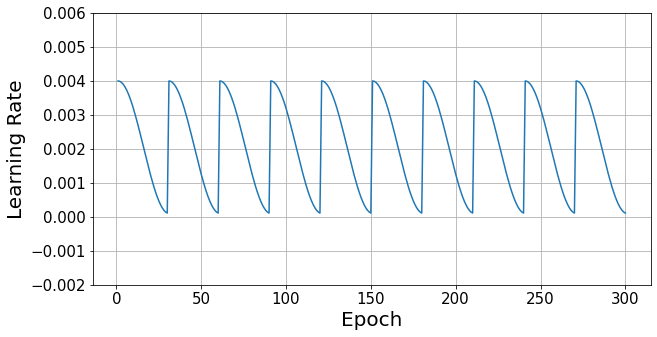

In [ ]:
fs = 20
Snap_Ens_LeLR_fig = plt.figure(figsize=(10,5))
x = np.arange(len(Snap_Ens_LeLR)) + 1
plt.plot(x, Snap_Ens_LeLR)
plt.grid()
plt.ylim(-0.002,0.006)
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Learning Rate',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [ ]:
Snap_Ens_LeLR_fig.savefig("Snap_Ens_LeLR_fig.png")

**Accuracy on Testset**

In [ ]:
nruntests = 1000
nbatch = 100
nclass = 10
nmodels = 10

with torch.no_grad(): 

    correct = 0

    for batch_id, sample in enumerate(fmnist_test_loader): 

        images, labels = sample
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)

        pred_list = torch.zeros((nruntests, nbatch, nclass)).to(device)

        for i in np.arange(nruntests): 

            model_num = np.random.randint(nmodels)
            model = Snap_Ens_LeModels[model_num]

            model.to(device)
            model.eval()

            pred = model(images)

            pred_list[i,:,:] = pred
        
        #print(pred_list.shape)

        pred_mean = torch.mean(pred_list, dim = 0)

        #print(pred_mean.shape)

        pred_labels = pred_mean.argmax(dim = 1)

        #print(pred_labels.shape)

        correct += pred_labels.eq(labels).float().sum().item()

    print("\nAccuracy on Test Set: {}/{} ({:.4f}%)\n".format(
    correct, len(fmnist_testset), correct/len(fmnist_testset) * 100.))
    
    Snap_Ens_Leacc = correct/len(fmnist_testset) * 100.


Accuracy on Test Set: 8891.0/10000 (88.9100%)



In [ ]:
np.save('./Snap_Ens_Leacc.npy', Snap_Ens_Leacc)

**Calculate Training Time**

In [ ]:
Snap_Ens_Letraining_start = time.time()

%time Snap_Ens_LeModels = snap_ensemble_BayesianLeNet5training(train_loader = fmnist_train_loader, val_loader = fmnist_val_loader, nepochs = 30, nmodels = 10, nbatch = 100, track = False)

Snap_Ens_Letraining_end = time.time()

Snap_Ens_Letraining_time = Snap_Ens_Letraining_end - Snap_Ens_Letraining_start

print(Snap_Ens_Letraining_time)

 	Epoch 1/300: Train step 500/500 loss = 750.5943
 	Epoch 2/300: Train step 500/500 loss = 707.5031
 	Epoch 3/300: Train step 500/500 loss = 699.5762
 	Epoch 4/300: Train step 500/500 loss = 676.8730
 	Epoch 5/300: Train step 500/500 loss = 683.7603
 	Epoch 6/300: Train step 500/500 loss = 678.5526
 	Epoch 7/300: Train step 500/500 loss = 673.0335
 	Epoch 8/300: Train step 500/500 loss = 655.3301
 	Epoch 9/300: Train step 500/500 loss = 667.2345
 	Epoch 10/300: Train step 500/500 loss = 656.8592
 	Epoch 11/300: Train step 500/500 loss = 644.1408
 	Epoch 12/300: Train step 500/500 loss = 642.9794
 	Epoch 13/300: Train step 500/500 loss = 656.5310
 	Epoch 14/300: Train step 500/500 loss = 635.5580
 	Epoch 15/300: Train step 500/500 loss = 628.9373
 	Epoch 16/300: Train step 500/500 loss = 632.3691
 	Epoch 17/300: Train step 500/500 loss = 621.2800
 	Epoch 18/300: Train step 500/500 loss = 633.7457
 	Epoch 19/300: Train step 500/500 loss = 620.8484
 	Epoch 20/300: Train step 500/500 loss 

In [ ]:
np.save('./Snap_Ens_Letraining_time.npy', Snap_Ens_Letraining_time)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
